### Setup

In [1]:
import os, sys
HOME = os.environ['HOME']  # change if necessary
sys.path.append(f'{HOME}/Finite-groups/src')

In [2]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
from irrep_bounds import *
from bound_utils import *
%load_ext autoreload
%autoreload 2

Syntax warning: Unbound global variable in /usr/share/gap/pkg/browse/PackageIn\
fo.g:73
  if not IsKernelExtensionAvailable("Browse", "ncurses") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/edim/PackageInfo\
.g:60
  if not IsKernelExtensionAvailable("EDIM","ediv") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^


In [3]:
t.manual_seed(42)    # clustering depends on random seed
np.random.seed(42)

In [4]:
t.set_grad_enabled(False)

In [5]:

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# MODEL_DIR = '2024-08-14_21-24-30_gapS_5_'
MODEL_DIR = '2024-09-18_23-59-00_gapS5_MLP2_128_wd2e-4_ubias'
# MODEL_DIR = '2024-09-22_22-12-21_gapF11_MLP2_256_wd1e-4_ubias'
# MODEL_DIR = '2024-09-23_01-06-18_A5x2_MLP2_128_wd1e-4_ubias'
# MODEL_DIR = '2024-09-23_02-50-16_sg96_227_MLP2_128_wd1e-4_ubias'

disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir,) #sel='final')
models = models[-1]  # get last checkpoint
data = GroupData(params)
group = data.groups[0]

/home/wilson/Finite-groups/src/model_utils.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


Intersection size: 14400/14400 (1.00)
Added 14400 elements from intersection
Added 0 elements from group 0: gapS(5)
Taking random subset: 5760/14400 (0.40)
Train set size: 5760/14400 (0.40)


In [6]:
irrep_idxs = []
for instance in tqdm(range(len(models))):
    model = models[instance]
    irreps, irrep_idx_dict = get_neuron_irreps(model, group, norm_thresh=1)
    irrep_idxs.append(irrep_idx_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


In [10]:
save = t.load('../data/acc_bound_S5_new.pt')
locals().update(save)

/tmp/ipykernel_188543/3089656520.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save = t.load('../data/acc_bound_S5_new.pt')


In [14]:
ideal_models = MLP2.stack(ideal_models)

In [ ]:
def ablate_loss(ln, rn, un):
    ablate_model = copy.deepcopy(model)
    if not isinstance(ablate_model, MLP4):
        ablate_model = ablate_model.fold_linear()
    ablate_model.embedding_left.data = ln.unsqueeze(0)
    ablate_model.embedding_right.data = rn.unsqueeze(0)
    ablate_model.unembedding.data = un.unsqueeze(0).mT
    return test_loss(ablate_model.to(device), data)

In [53]:
if not isinstance(models, MLP4):
    models = models.fold_linear()
if not isinstance(ideal_models, MLP4):
    ideal_models = ideal_models.fold_linear()

In [56]:
swap_models = dict()
for name, param in ideal_models.named_parameters():
    swap_models[name] = copy.deepcopy(models)
    swap_models[name].get_parameter(name).data = param.data.clone()

In [ ]:
orig_loss = test_loss(models, data)
ideal_loss = test_loss(ideal_models, data)
swap_loss = {name: test_loss(model, data) for name, model in swap_models.items()}

/tmp/ipykernel_188543/4290446236.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  plt.plot(np.arange(min(ideal_loss_good), max(orig_loss_good)+0.001, 0.001), np.arange(min(ideal_loss_good), max(orig_loss_good)+0.001, 0.001), 'k', linestyle='--')


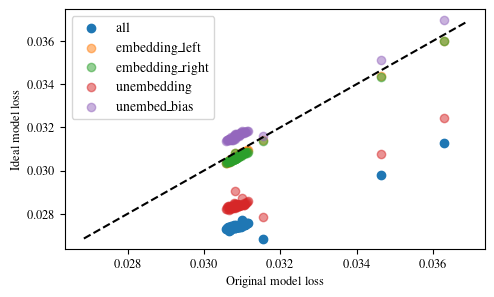

In [119]:
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('axes', labelsize=9)

width = 5
height = 3
fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.17, right=.99, top=.97)

orig_loss_good = [orig_loss['G0_loss'][i] for i in range(len(models)) if i not in avar_bad and i not in irrep_bad]
ideal_loss_good = [ideal_loss['G0_loss'][i] for i in range(len(models)) if i not in avar_bad and i not in irrep_bad]
swap_loss_good = {name: [swap_loss[name]['G0_loss'][i] for i in range(len(models)) if i not in avar_bad and i not in irrep_bad] for name in swap_models}
plt.scatter(orig_loss_good, ideal_loss_good, label='all')
for name in swap_models:
    plt.scatter(orig_loss_good, swap_loss_good[name], label=name, alpha=0.5)
plt.plot(np.arange(min(ideal_loss_good), max(orig_loss_good)+0.001, 0.001), np.arange(min(ideal_loss_good), max(orig_loss_good)+0.001, 0.001), 'k', linestyle='--')
plt.xlabel('Original model loss')
plt.ylabel('Ideal model loss')
fig.set_size_inches(width, height)
plt.legend()
fig.savefig('../figs/loss_swap_param_S5.pdf')
plt.show()

In [99]:
models.unembed_bias.shape

torch.Size([100, 120])

In [126]:
irrep_swap_models = dict()
for irrep in ['all_irreps', '1d-0', '4d-1', '5d-0']:
    irrep_swap_models[irrep] = copy.deepcopy(models)
    for i in range(100):
        if irrep == 'all_irreps':
            idxs = list(set(sum(irrep_idxs[i].values(), [])))
        else:
            idxs = irrep_idxs[i][irrep]
        # print((irrep_swap_models[irrep].embedding_left[i,:,idxs] - ideal_models.embedding_left.data[i,:,idxs]).norm())
        irrep_swap_models[irrep].embedding_left.data[i,:,idxs] = ideal_models.embedding_left.data[i,:,idxs].clone()
        irrep_swap_models[irrep].embedding_right.data[i,:,idxs] = ideal_models.embedding_right.data[i,:,idxs].clone()
        irrep_swap_models[irrep].unembedding.data[i,idxs] = ideal_models.unembedding.data[i,idxs].clone()

In [127]:
irrep_swap_loss = {name: test_loss(model, data) for name, model in irrep_swap_models.items()}

In [128]:
# Paper uses different irrep names than code :(
irrep_swap_loss['4d-0'] = irrep_swap_loss['4d-1']
del irrep_swap_loss['4d-1']
irrep_swap_loss['1d-1'] = irrep_swap_loss['1d-0']
del irrep_swap_loss['1d-0']

/tmp/ipykernel_188543/3131496738.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  plt.plot(np.arange(min(ideal_loss_good), max(orig_loss_good)+0.001, 0.001), np.arange(min(ideal_loss_good), max(orig_loss_good)+0.001, 0.001), 'k', linestyle='--')


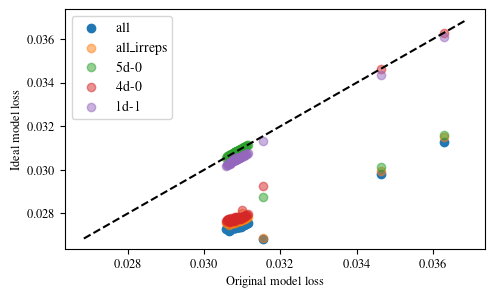

In [132]:
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('axes', labelsize=9)

width = 5
height = 3
fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.17, right=.99, top=.97)

irrep_swap_loss_good = {name: [irrep_swap_loss[name]['G0_loss'][i] for i in range(len(models)) if i not in avar_bad and i not in irrep_bad] for name in irrep_swap_loss}
plt.scatter(orig_loss_good, ideal_loss_good, label='all')
for name in irrep_swap_loss:
    plt.scatter(orig_loss_good, irrep_swap_loss_good[name], label=name, alpha=0.5)
plt.plot(np.arange(min(ideal_loss_good), max(orig_loss_good)+0.001, 0.001), np.arange(min(ideal_loss_good), max(orig_loss_good)+0.001, 0.001), 'k', linestyle='--')
plt.xlabel('Original model loss')
plt.ylabel('Ideal model loss')
fig.set_size_inches(width, height)
plt.legend()
fig.savefig('../figs/loss_swap_irrep_S5.pdf')
plt.show()

In [72]:
avar, loss, norm = t.load('../data/avar_loss_norm.pt')

/tmp/ipykernel_188543/2955975962.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  avar, loss, norm = t.load('../data/avar_loss_norm.pt')


### avar vs loss/norm plots

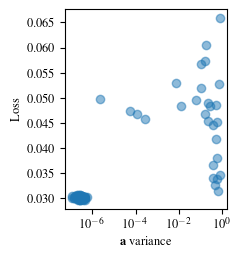

In [93]:
# TODO: this is not the right notebook for this...

fig, ax = plt.subplots()
fig.subplots_adjust(left=.25, bottom=.17, right=.90, top=.97)
plt.scatter(avar, loss, alpha=0.5)
plt.xscale('log')
plt.xlabel('$\mathbf{a}$ variance')
plt.ylabel('Loss')
fig.set_size_inches(2.5, 2.5)
fig.savefig('../figs/avar_loss.pdf')
plt.show()

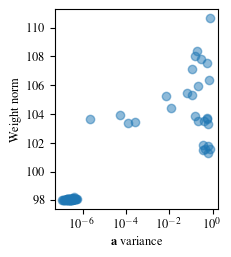

In [95]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=.25, bottom=.17, right=.90, top=.97)
plt.scatter(avar, norm, alpha=0.5)
plt.xscale('log')
plt.xlabel('$\mathbf{a}$ variance')
plt.ylabel('Weight norm')
fig.set_size_inches(2.5, 2.5)
fig.savefig('../figs/avar_norm.pdf')
plt.show()